In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset
import seaborn as sns

/tmp/ipykernel_5645/4090892198.py:7: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [2]:
iris=sns.load_dataset('iris')
iris
data=iris.drop(columns=['species']).values
data=torch.tensor(data).float()

labels=torch.zeros(len(data),dtype=torch.long)
labels[iris.species=='versicolor']=1
labels[iris.species=='virginica']=2


In [3]:
X_train, X_test, y_train, y_test = train_test_split(
data, labels, test_size=0.2, random_state=42)
train_data=TensorDataset(X_train,y_train) 
test_data=TensorDataset(X_test,y_test)


In [4]:
def createANNmodel():
    ANNiris=nn.Sequential(nn.Linear(4,64),
                         nn.ReLU(),
                         nn.Linear(64,64),
                         nn.ReLU(),

                         nn.Linear(64,3),   
                         )
    lossfun=nn.CrossEntropyLoss()
    optimizer=torch.optim.SGD(ANNiris.parameters(),lr=0.001)
    return ANNiris,lossfun,optimizer

In [5]:
numepochs=500
def trainModel():
    trainAcc=[]
    testAcc=[]
    losses=[]
    for epochi in range(numepochs):
        ANNiris.train()
        batchAcc=[]
        batchLoss=[]
        for X,y in train_loader:
            yHat=ANNiris(X)
            loss=lossfun(yHat,y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batchAcc.append(100*torch.mean((torch.argmax(yHat,axis=1)==y).float()).item())
            batchLoss.append(loss.item())
            
        trainAcc.append(np.mean(batchAcc))
        losses.append(np.mean(batchLoss))
        
        X,y=next(iter(test_loader))
        ANNiris.eval()
        with torch.no_grad():
           
            predlabels=torch.argmax(ANNiris(X),axis=1)
        
        testAcc.append(100*torch.mean((predlabels==y).float()).item())
        
    return trainAcc,testAcc,losses
            

In [7]:
batchsizes=2**np.arange(1,7)
accuracyResultsTrain=np.zeros((numepochs,len(batchsizes)))
accuracyResultsTest=np.zeros((numepochs,len(batchsizes)))
test_loader=DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])
for bi in range(len(batchsizes)):
    train_loader=DataLoader(train_data,batch_size=int(batchsizes[bi]), shuffle=True,drop_last=True)
    
    ANNiris,lossfun,optimizer=createANNmodel()
    trainAcc,testAcc,losses=trainModel()
    accuracyResultsTrain[:,bi]=trainAcc
    accuracyResultsTest[:,bi]=testAcc
    
    


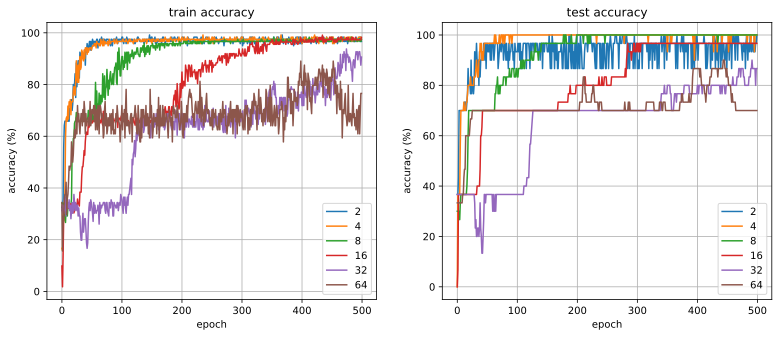

In [8]:
fig,ax=plt.subplots(1,2,figsize=(13,5))
ax[0].plot(accuracyResultsTrain)
ax[0].set_title('train accuracy')
ax[1].plot(accuracyResultsTest)
ax[1].set_title('test accuracy')
for i in range(2):
    ax[i].legend(batchsizes)
    ax[i].set_xlabel('epoch')
    ax[i].set_ylabel('accuracy (%)')
    ax[i].grid()
    